In [2]:
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt
import seaborn as sns

import bk.load
import bk.compute
import bk.plot
import bk.signal

from pactools import Comodulogram, REFERENCES
from pactools import simulate_pac


In [3]:
def plot_comodulogram(signal):
    fs = 1250.  # Hz
    low_fq_width = 1  # Hz
    low_fq_range = np.linspace(1, 10, 50)
    methods = [
        'ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
        'sigl', 'bispectrum'
    ]

    # Define the subplots where the comodulogram will be plotted
    n_lines = 3
    n_columns = int(np.ceil(len(methods) / float(n_lines)))
    fig, axs = plt.subplots(
        n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
    axs = axs.ravel()


    # Compute the comodulograms and plot them
    for ax, method in zip(axs, methods):
        print('%s... ' % (method, ))
        estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                                low_fq_width=low_fq_width, method=method,
                                progress_bar=True,n_jobs=12)
        estimator.fit(signal)
        estimator.plot(titles=[REFERENCES[method]], axs=[ax])
        ax.set_ylim(0,200)

    plt.show()

In [4]:
def plot_comodulogram(signal,method = 'tort',ax = None):
    fs = 1250.  # Hz
    low_fq_width = 1  # Hz
    low_fq_range = np.linspace(1, 10, 50)

    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                                low_fq_width=low_fq_width, method=method,
                                 progress_bar=True,n_jobs=12)
    estimator.fit(signal)


    if ax is None:
        fig,ax = plt.subplots()
    estimator.plot(titles=[REFERENCES[method]], axs=[ax])
    ax.set_ylim(0,200)

In [5]:
bk.load.current_session_linux(byrat=8,byday=4)
states = bk.load.states(True)

lfp = bk.load.lfp(23,0,50)

Rat : 8 on day : 4
Working with session Rat08-20130711 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130711


In [20]:
def plot_comod(comods,estimator,ax = None,cmap = None,vmin = None,vmax = None):
        m_comod = np.nanmean(comods,0)
        
        extent = [
            estimator.low_fq_range[0],
            estimator.low_fq_range[-1],
            estimator.high_fq_range[0],
            estimator.high_fq_range[-1],
        ]
        print(extent)
        if ax is None:
            fig,ax = plt.subplots()
        
        # Get auto values for vmin, vmax
        if vmin is None and vmax is None:
            vmin = min(0, m_comod.min())
            vmax = max(0, m_comod.max())
            if vmin < 0 and vmax > 0:
                vmax = max(vmax, -vmin)
                vmin = -vmax
                if cmap is None:
                    cmap = plt.get_cmap('RdBu_r')
        if cmap is None:
            cmap = plt.get_cmap('viridis')


        cax = ax.imshow(m_comod.T, cmap=cmap, vmin=vmin, vmax=vmax,
                                aspect='auto', origin='lower', extent=extent,
                                interpolation='none')

In [34]:
fs = 1250.  # Hz
low_fq_width = 1  # Hz
low_fq_range = np.linspace(1, 10, 50)
estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                         low_fq_width=low_fq_width, method='tort',
                         progress_bar=True, n_jobs=12)
comods = {}
for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
    comods[state] = {'BLA': [],
                     'BLA_HPC': [],
                     'HPC_BLA': []}
    
    for start, stop in states[state].as_units('s').iloc:
        signal_bla = bk.load.lfp(bk.load.bla_channels()['right'], start, stop)
        signal_hpc = bk.load.lfp(bk.load.ripple_channel(), start, stop)
        
        estimator.fit(signal_bla.values)
        comods[state]['BLA'].append(estimator.comod_)

        estimator.fit(signal_bla.values,signal_hpc)
        comods[state]['BLA_HPC'].append(estimator.comod_)

        estimator.fit(signal_hpc.values,signal_bla)
        comods[state]['HPC_BLA'].append(estimator.comod_)

[........................................] 100% | 16.42 sec | comodulogram: tort 
[........................................] 100% | 14.82 sec | comodulogram: tort 
[........................................] 100% | 14.76 sec | comodulogram: tort 
[........................................] 100% | 20.97 sec | comodulogram: tort 
[........................................] 100% | 20.96 sec | comodulogram: tort 
[........................................] 100% | 21.00 sec | comodulogram: tort 
[........................................] 100% | 61.53 sec | comodulogram: tort 
[........................................] 100% | 61.24 sec | comodulogram: tort 
[........................................] 100% | 61.55 sec | comodulogram: tort 
[........................................] 100% | 4.65 sec | comodulogram: tort 
[........................................] 100% | 4.67 sec | comodulogram: tort 
[........................................] 100% | 4.72 sec | comodulogram: tort 
[..................

In [45]:
%matplotlib qt
plot_comod(comods['REM']['BLA'],estimator,vmin = 0,vmax = 0.01)
plt.ylim(10,200)

fig,ax = plt.subplots(1,3)
for i,case in enumerate(['BLA','BLA_HPC','HPC_BLA']):
    plot_comod(comods['REM'][case],estimator,vmin = 0,vmax = 0.001,ax = ax[i])
    ax[i].set_ylim(10,200)
    ax[i].set_title(case)
plt.tight_layout()


[1.0, 10.0, 10.0, 625.0]
[1.0, 10.0, 10.0, 625.0]
[1.0, 10.0, 10.0, 625.0]
[1.0, 10.0, 10.0, 625.0]


In [15]:
%matplotlib qt
bk.load.current_session_linux(byrat=8,byday=4)
states = bk.load.states(True)
fig,ax = plt.subplots(2,2)
for i,state in enumerate(['REM','NREM']):
    for j,stru in enumerate(['BLA','Hpc']):
        if stru == 'BLA':
            signal = bk.load.lfp_in_intervals(bk.load.bla_channels()['left'],states[state])
        else:
            signal = bk.load.lfp_in_intervals(bk.load.ripple_channel(),states[state])
        plot_comodulogram(signal,'tort',ax[j,i])
        ax[j,i].set_title(state+stru)

Rat : 8 on day : 4
Working with session Rat08-20130711 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130711


AttributeError: 'Series' object has no attribute 'as_units'

In [7]:
bk.load.current_session_linux()
states = bk.load.states()

for state in ['Rem','sws']:
    for stru in ['BLA','Hpc']:
        print(state+stru)
        if stru == 'BLA':
            signal = bk.load.lfp_in_intervals(bk.load.bla_channels()['left'],states[state]).values[0:1_000_000]
        else:
            signal = bk.load.lfp_in_intervals(bk.load.ripple_channel(),states[state]).values[0:1_000_000]
        plot_comodulogram(signal)
        plt.title(f'{stru} during {state}')

Using matplotlib backend: Qt5Agg
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
RemBLA
ozkurt... 
[........................................] 100% | 39.94 sec | comodulogram: ozkurt 
canolty... 
[........................................] 100% | 39.43 sec | comodulogram: canolty 
tort... 
[........................................] 100% | 64.80 sec | comodulogram: tort 
penny... 
[........................................] 100% | 96.31 sec | comodulogram: penny 
vanwijk... 
[........................................] 100% | 116.22 sec | comodulogram: vanwijk 
duprelatour... 
[........................................] 100% | 16.28 sec | comodulogram: DAR(10, 1) 
[........................................] 100% | 18.12 sec | comodulogram: DAR(10, 1) colgin... 
[........................................] 100% | 9.00 sec | coherence: colgin 
sigl... 
[........................................] 100% | 3.12 sec | bicoherence: 

NameError: name 'session' is not defined

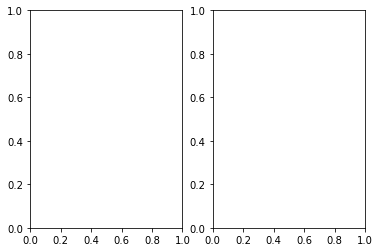

In [3]:
# Surrogates of the Tort methods : 
low_fq_range = np.linspace(1, 10, 50)
method = 'tort'  # or 'tort', 'ozkurt', 'penny', 'colgin', ...
n_surrogates = 200
n_jobs = 12

fig,axs = plt.subplots(1,2)
estimator = {}
for i,state in enumerate(['Rem','sws']):
    signal = bk.load.lfp_in_intervals(bk.load.ripple_channel(),states[state]).values[0:1_000_000]

    estimator[state] = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                            low_fq_width=low_fq_width, method=method,
                            n_surrogates=n_surrogates, progress_bar=True,
                            n_jobs=n_jobs)
    estimator[state].fit(signal)

    p_value = 0.05
    estimator[state].plot(contour_method='comod_max', contour_level=p_value,
                titles=[f'{state}'],
                axs=[axs[i]])
    plt.show()

In [5]:
# Surrogates of the Tort methods : 

%matplotlib
bk.load.current_session_linux()
states = bk.load.states()

low_fq_range = np.linspace(1, 10, 50)
method = 'tort'  # or 'tort', 'ozkurt', 'penny', 'colgin', ...
n_surrogates = 200
n_jobs = 12

fig,axs = plt.subplots(1,2)
estimator = {}
for i,state in enumerate(['Rem','sws']):
    signal = bk.load.lfp_in_intervals(bk.load.bla_channels()['left'],states[state]).values[0:1_000_000]

    estimator[state] = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                            low_fq_width=low_fq_width, method=method,
                            n_surrogates=n_surrogates, progress_bar=True,
                            n_jobs=n_jobs)
    estimator[state].fit(signal)

    p_value = 0.05
    estimator[state].plot(contour_method='comod_max', contour_level=p_value,
                titles=[f'{state}]'],
                axs=[axs[i]])
    plt.show()

Using matplotlib backend: Qt5Agg
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
[........................................] 100% | 9665.51 sec | comodulogram: tort 


/home/billel/anaconda3/lib/python3.9/site-packages/pactools/comodulogram.py:506: UserWarning: No contour levels were found within the data range.
  axs[i].contour(comod_[i].T, levels=levels, colors='w',


[........................................] 100% | 9412.74 sec | comodulogram: tort 


In [35]:
fig,axs = plt.subplots(1,2)

estimator.plot(contour_method='z_score', contour_level=5,
               titles=['With a z-score on each couple of frequency'],
               axs=[axs[0]])
plt.title(state)
plt.ylim(10,200)
plt.show()